# Explainability of Neural Network Models for Time Series

## Notebook Overview
The aim is to identify and quantify the most relevant input features influencing model performance.

## Imports

In [39]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderRefined as ae
from dl_models import LSTMBasic as lstm
from dl_models import AutoencoderLSTM as ael
from utils import plots as plts
from utils import importance as im

## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

## Phase 1: Identifying Important Features
- Train initial models on the full feature set.
- Compute permutation feature importance by measuring error increase when permuting each feature.
- Visualize importance with bar plots (mean and std deviation of error increase).

In [2]:
X_test_seq_ae, X_test_pred_ae, model_ae = ae.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)

Epoch 1/3000
6/6 [==============================] - 1s 5ms/step - loss: 0.1331 - mean_absolute_error: 0.3241
Epoch 2/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1194 - mean_absolute_error: 0.3077
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1028 - mean_absolute_error: 0.2855
Epoch 4/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0846 - mean_absolute_error: 0.2574
Epoch 5/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0685 - mean_absolute_error: 0.2274
Epoch 6/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0574 - mean_absolute_error: 0.2013
Epoch 7/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0509 - mean_absolute_error: 0.1819
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0464 - mean_absolute_error: 0.1677
Epoch 9/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0425 - mean_absolute_error: 0.1572
Epoch 10/3000
6/6 [

In [3]:
X_test_seq_lstm, y_test, y_pred_lstm, model_lstm = lstm.lstm_forecast(train_df=train_df, test_df=test_df, features=features, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 2s - loss: 0.0581 - 2s/epoch - 53ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0232 - 213ms/epoch - 5ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0193 - 164ms/epoch - 4ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0175 - 155ms/epoch - 3ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0162 - 157ms/epoch - 3ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0152 - 145ms/epoch - 3ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0146 - 150ms/epoch - 3ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0138 - 157ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0133 - 156ms/epoch - 3ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0129 - 154ms/epoch - 3ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0124 - 154ms/epoch - 3ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0122 - 158ms/epoch - 4ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0116 - 154ms/epoch - 3ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0114 - 148ms/epoch - 3ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0110 - 147ms/epoch - 3ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0109 - 146ms/epoc

In [4]:
X_test_seq_ael, X_test_pred_ael, model_ael = ael.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 150, batch_size = 64, latent_dim = 256, timesteps = 6)

Epoch 1/150
12/12 [==============================] - 2s 31ms/step - loss: 0.1278
Epoch 2/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0647
Epoch 3/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0426
Epoch 4/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0311
Epoch 5/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0253
Epoch 6/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0211
Epoch 7/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0182
Epoch 8/150
12/12 [==============================] - 0s 29ms/step - loss: 0.0163
Epoch 9/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0152
Epoch 10/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0143
Epoch 11/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0135
Epoch 12/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0128
Epoch 13/150
12/12 [=====

In [5]:
means_ae, stds_ae = im.importance_autoencoder(model_ae, X_test_seq_ae, features)
sorted_idx_ae = np.argsort(means_ae)

45/45 [==============================] - 0s 1ms/step


In [6]:
means_lstm, stds_lstm = im.importance_lstm(model_lstm, X_test_seq_lstm, y_test, features)
sorted_idx_lstm = np.argsort(means_lstm)

45/45 [==============================] - 0s 2ms/step


In [7]:
means_ael, stds_ael = im.importance_autoencoder_lstm(model_ael, X_test_seq_ael, features)
sorted_idx_ael = np.argsort(means_ael)

45/45 [==============================] - 0s 4ms/step


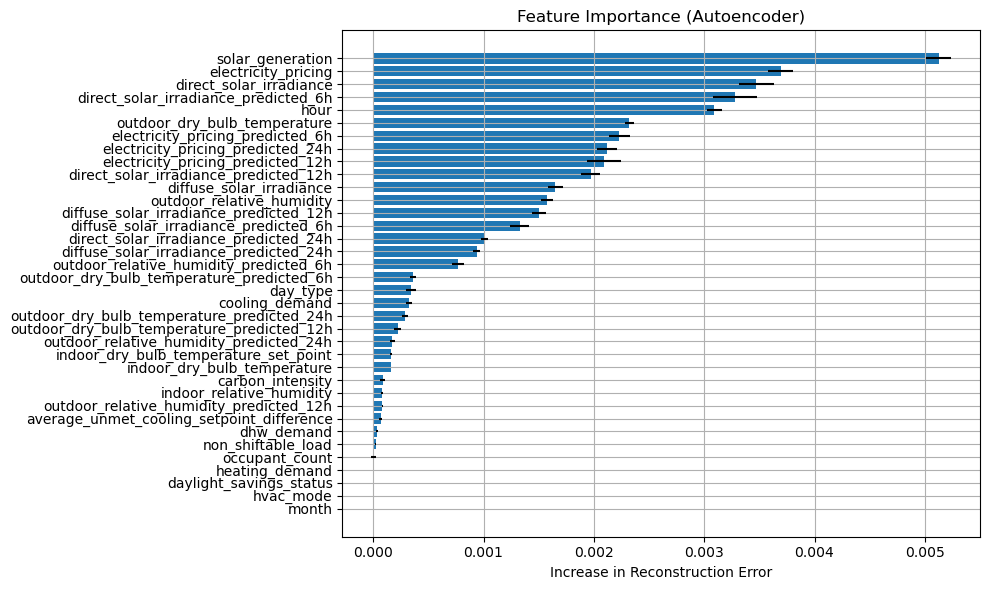

In [9]:
plts.plot_feature_importance(features, means_ae, stds_ae, title="Feature Importance (Autoencoder)")

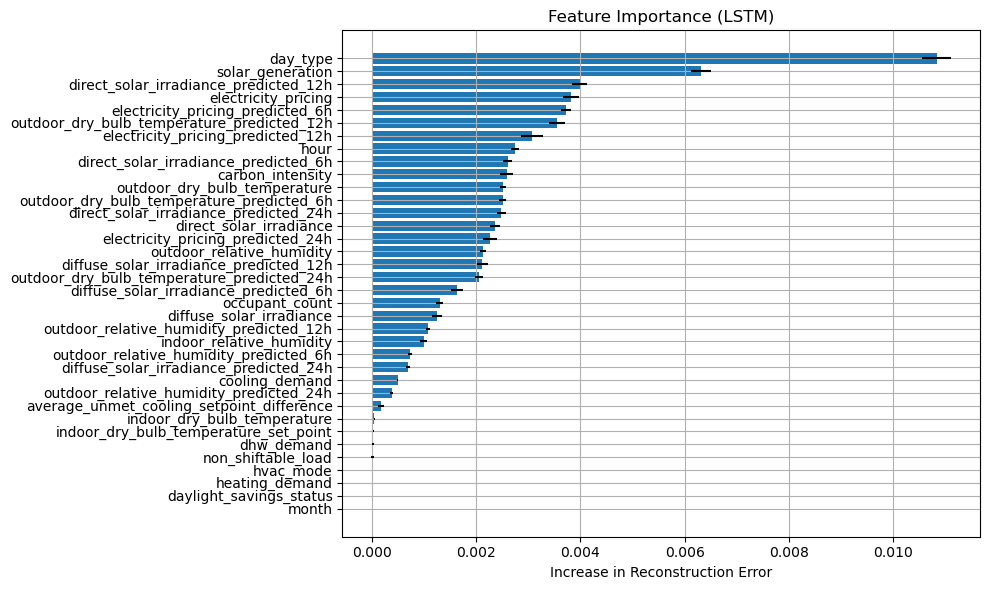

In [10]:
plts.plot_feature_importance(features, means_lstm, stds_lstm, title="Feature Importance (LSTM)")

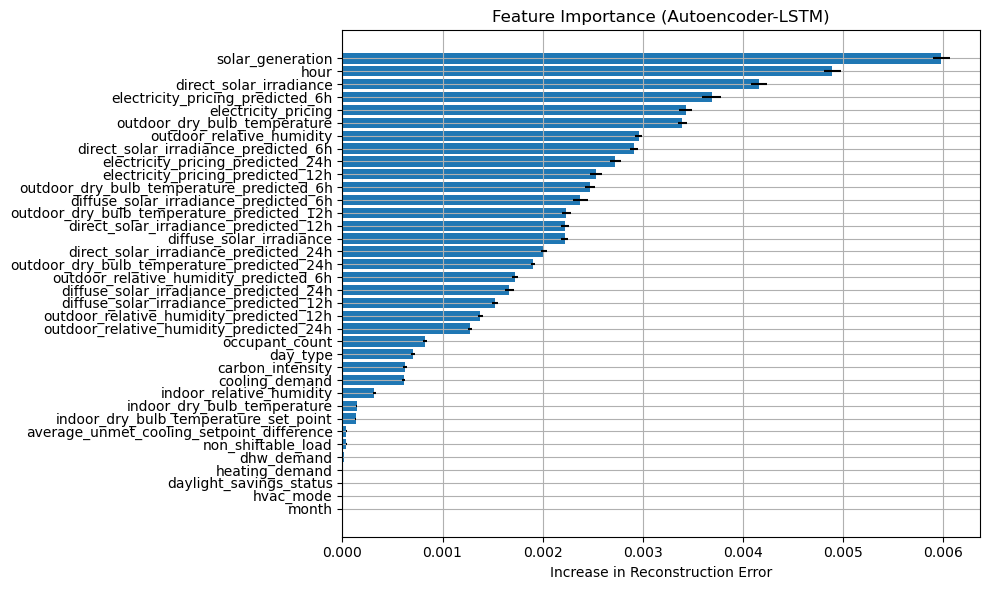

In [11]:
plts.plot_feature_importance(features, means_ael, stds_ael, title="Feature Importance (Autoencoder-LSTM)")

## Phase 2: Training on Relevant Features
- Select top-N features according to importance scores, adding required target features if missing.
- Prepare reduced datasets containing only these features.
- Retrain models on the reduced datasets.
- Compare prediction results with those obtained using the full feature set (see the generalization notebook).

In [31]:
sorted_idx_ae_inv = sorted_idx_ae[::-1]
sorted_idx_lstm_inv = sorted_idx_lstm[::-1]
sorted_idx_ael_inv = sorted_idx_ael[::-1]

top5_ae = sorted_idx_ae_inv[:5]
top5_lstm = sorted_idx_lstm_inv[:5]
top5_ael = sorted_idx_ael_inv[:5]

top5_features_ae = [features[i] for i in top5_ae]
top5_features_lstm = [features[i] for i in top5_lstm]
top5_features_ael = [features[i] for i in top5_ael]

features_ae = [col for col in features if col in set(top5_features_ae + targets)]
features_lstm = [col for col in features if col in set(top5_features_lstm + targets)]
features_ael = [col for col in features if col in set(top5_features_ael + targets)]

train_df_relevant_ae = train_df[features_ae].copy()
test_df_relevant_ae = test_df[features_ae].copy()
train_df_relevant_lstm = train_df[features_lstm].copy()
test_df_relevant_lstm = test_df[features_lstm].copy()
train_df_relevant_ael = train_df[features_ael].copy()
test_df_relevant_ael = test_df[features_ael].copy()

In [32]:
real_ae, pred_ae, model_ae = ae.Autoencoder(train_df=train_df_relevant_ae, test_df=test_df_relevant_ae, features=top5_features_ae, epochs = 3000, latent_dim = 32, batch_size = 128)

Epoch 1/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.1527 - mean_absolute_error: 0.3578
Epoch 2/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1350 - mean_absolute_error: 0.3376
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1166 - mean_absolute_error: 0.3138
Epoch 4/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0990 - mean_absolute_error: 0.2859
Epoch 5/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0842 - mean_absolute_error: 0.2580
Epoch 6/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0697 - mean_absolute_error: 0.2298
Epoch 7/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0556 - mean_absolute_error: 0.2016
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0435 - mean_absolute_error: 0.1760
Epoch 9/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0337 - mean_absolute_error: 0.1531
Epoch 10/3000
6/6 [

In [46]:
real_lstm, real_lstm, pred_lstm, model_lstm = lstm.lstm_forecast(train_df=train_df_relevant_lstm, test_df=test_df_relevant_lstm, features=top5_features_lstm, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 1s - loss: 0.0571 - 1s/epoch - 27ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0287 - 177ms/epoch - 4ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0222 - 162ms/epoch - 4ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0183 - 168ms/epoch - 4ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0157 - 161ms/epoch - 4ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0138 - 152ms/epoch - 3ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0130 - 153ms/epoch - 3ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0122 - 157ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0126 - 164ms/epoch - 4ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0110 - 213ms/epoch - 5ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0105 - 173ms/epoch - 4ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0104 - 190ms/epoch - 4ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0101 - 188ms/epoch - 4ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0094 - 162ms/epoch - 4ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0094 - 147ms/epoch - 3ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0096 - 154ms/epoc

In [34]:
real_ael, pred_ael, model_ael = ael.Autoencoder(train_df=train_df_relevant_ael, test_df=test_df_relevant_ael, features=top5_features_ael, epochs = 150, batch_size = 64, latent_dim = 256, timesteps = 6)

Epoch 1/150
12/12 [==============================] - 2s 34ms/step - loss: 0.1291
Epoch 2/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0743
Epoch 3/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0569
Epoch 4/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0443
Epoch 5/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0370
Epoch 6/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0323
Epoch 7/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0284
Epoch 8/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0253
Epoch 9/150
12/12 [==============================] - 0s 26ms/step - loss: 0.0227
Epoch 10/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0206
Epoch 11/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0185
Epoch 12/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0171
Epoch 13/150
12/12 [=====

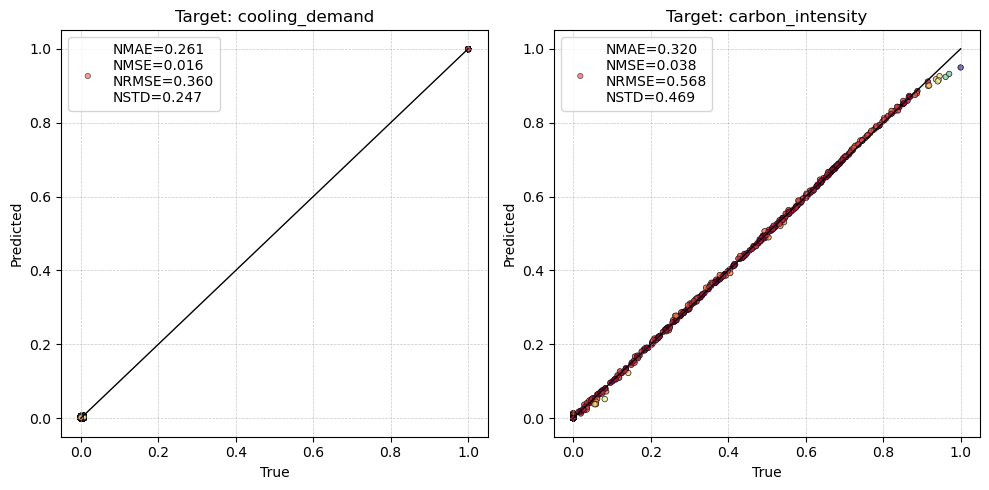

In [40]:
plts.plot_targets(real_ae, pred_ae, targets, features_ae, percent=True)

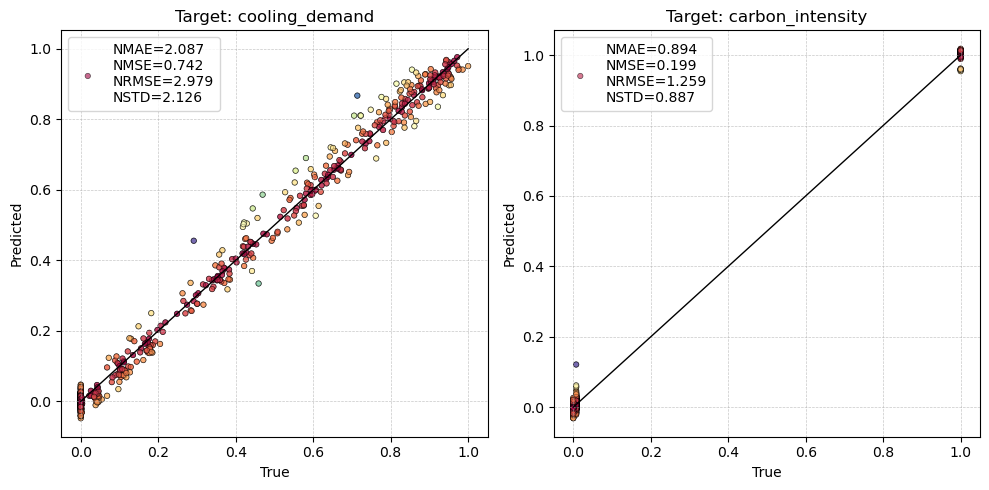

In [48]:
plts.plot_targets(real_lstm, pred_lstm, targets, features_lstm, percent=True)

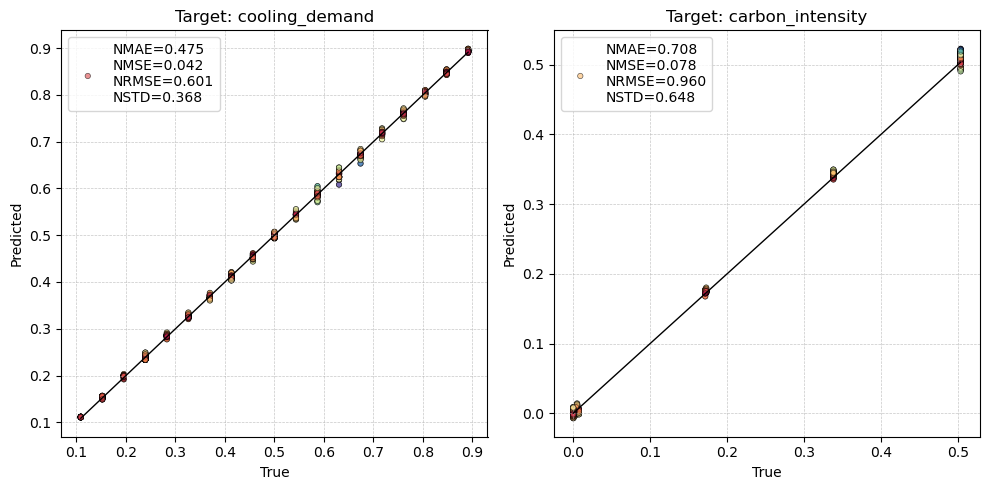

In [43]:
plts.plot_aelstm_targets(real_ael, pred_ael, targets, features_ael, percent=True)